# Тема: Классификация текстов с использованием наивного байесовского классификатора

Цель работы: построить модель классификации, позволяющей с высокой точностью отличать спам от нормальной почты. 

Данные: в работе использован готовый размеченный датасет spam_or_not_spam.csv (источник - https://www.kaggle.com/datasets/ozlerhakan/spam-or-not-spam-dataset )




In [1]:
#Импорт нужных в работе библиотек
import warnings
warnings.filterwarnings('ignore')

#Для работы с датасетом
import pandas as pd

#Для векторных преобразований и вычислений
import numpy as np

#Для визуализаций
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

#Для работы с текстами писем
from sklearn.feature_extraction.text import CountVectorizer

#Для построения модели классификатора
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB

#Для оценки качества модели
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


## Знакомство с данными

Откроем данные. Оценим, сколько в них спам- и не спам-писем. Визуализируем полученные соотношение подходящим образом.

In [2]:
# Откроем данные
data = pd.read_csv('data/spam_or_not_spam.csv')
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [3]:
#Рассчитаем частоты для классов : 
data['label'].value_counts()

0    2500
1     500
Name: label, dtype: int64

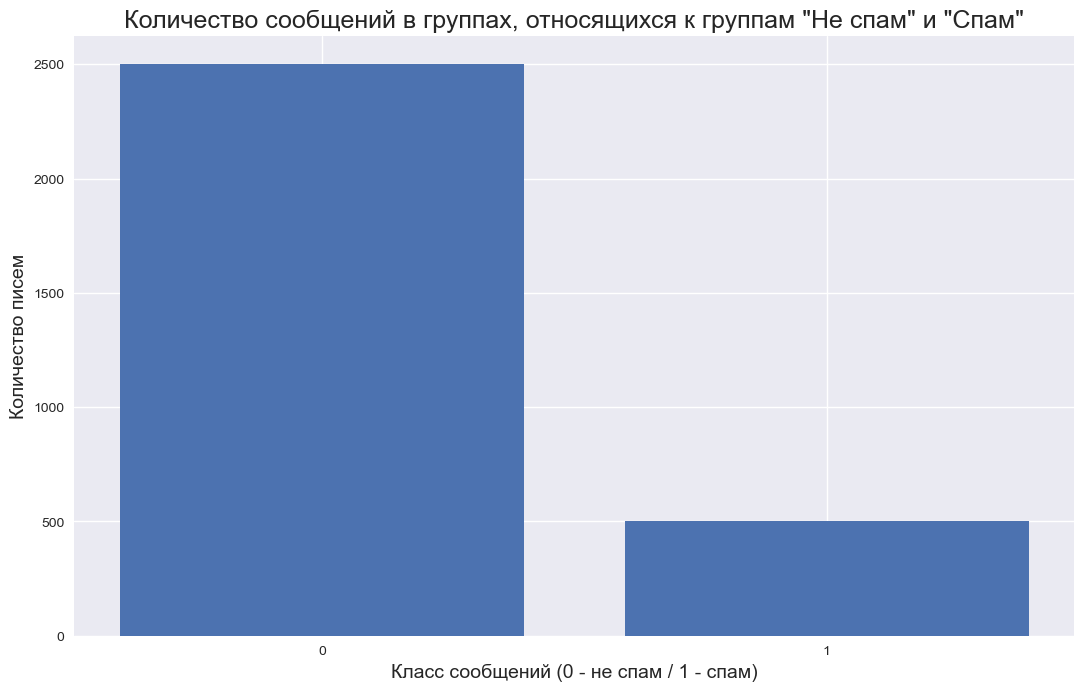

In [4]:
#Визуализируем результат:
grouped = data['label'].value_counts()

fig = plt.figure(figsize=(10, 6))
axes = fig.add_axes([0, 0, 1, 1])

axes.bar(x=grouped.index, height = grouped);
axes.set_ylabel('Количество писем', fontsize=14)
axes.set_xlabel('Класс сообщений (0 - не спам / 1 - спам)', fontsize=14)
axes.set_xticks([0,1])
axes.set_title('Количество сообщений в группах, относящихся к группам "Не спам" и "Спам"', fontsize=18)
plt.show()

## Предобработка данных

Предобработаем данные и переведём их в векторный вид с помощью векторайзера.

In [5]:
#Удалим пропуски и разные ненужные нам символы в текстах писем
data['email'] = data['email'].str.replace('\W+', ' ').str.replace('\s+', ' ').str.strip()
data = data.dropna()
data

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMBE...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which h...,0
...,...,...
2995,abc s good morning america ranks it the NUMBER...,1
2996,hyperlink hyperlink hyperlink let mortgage len...,1
2997,thank you for shopping with us gifts for all o...,1
2998,the famous ebay marketing e course learn to se...,1


In [6]:
#Оценим количество пропусков в данных
data.isna().sum()

email    0
label    0
dtype: int64

Переведём данные в векторный вид.

- Векторайзер создаёт разреженную матрицу из всех слов, встречающихся в письмах.
- Строки матрицы соответствуют конкретному сообщению из исходных данных, столбцы соответствуют конкретному слову.
- В ячейках матрицы находятся числа - частота встречаемости данного слова в данном письме.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [7]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["email"])

In [8]:
#Определим, сколько теперь признаков в нашем наборе данных:
len(vectorizer.get_feature_names_out())

34116

In [9]:
#Переведём полученные признаки в удобный табличный формат
word_count = pd.DataFrame(X.toarray(), columns=list(vectorizer.get_feature_names_out()))
word_count.head()

,__,___,____,_____,______,_______,________,_________,__________,______________,...,허락없이,헤어디자이너,현재,호황을,홈쇼핑의,확실한,활황을,훨씬,힘입어,ｉt的技
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
word_count.shape

(2999, 34116)

## Построение модели классификации 

In [12]:
#Определим целевую переменную и признаки
X = word_count
y = data['label']

Разделим выборку на обучающую и тестовую, размер тестовой выборки определим как 0.25, параметр random_state определим со значением 42:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Определим и обучим подходящий алгоритм с параметром alpha = 0.01

В библиотеке sklearn есть несколько байесовских классификаторов:

- GaussianNB — самый простой вариант, работает с непрерывными признаками;
- MultinomialNB  — работает с категориальными признаками, текстами и несбалансированными выборками;
- ComplementNB — улучшенная версия MultinomialNB, стабильно показывает более высокое качество в задачах классификации текстов;
- BernoulliNB — версия для работы с бинарными признаками;
- CategoricalNB — работает с категориальными признаками, предполагает кодировку данных через OrdinalEncoder.

In [16]:
#Используем алгоритм ComplementNB, так как он работает с категориальными признаками, текстами и несбалансированными выборками
#Это как раз наш случай
clf = ComplementNB(alpha=0.01)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


Оценим результат различными метриками классификации:

In [17]:
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(f1_score(y_test,y_pred))


0.9946666666666667
0.983739837398374
0.983739837398374
0.983739837398374


Оценим качество модели визуально. Нарисуем ROC-кривую:

- ROC - Receiver Operating Characteristic curve.

![](img/roc_curve.png)


In [18]:
#Определим вероятности для наших прогнозов
y_pred_prob = clf.predict_proba(X_test)
y_pred_prob

array([[1.00000000e+000, 1.75520053e-108],
       [1.00000000e+000, 5.47883399e-053],
       [1.00000000e+000, 6.32532989e-016],
       ...,
       [1.00000000e+000, 2.89029174e-126],
       [1.07492037e-009, 9.99999999e-001],
       [1.00000000e+000, 3.34551897e-087]])

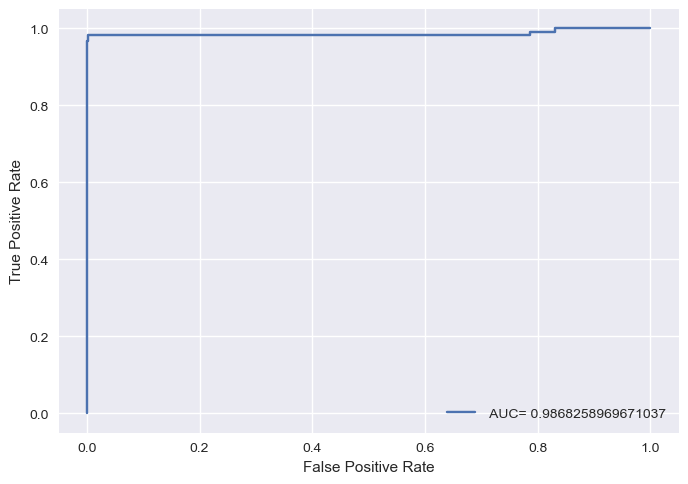

In [19]:
#Строим кривую
fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:,1])
auc = roc_auc_score(y_test, y_pred_prob[:,1])

#create ROC curve
plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show() 


## Подбор гиперпараметра alpha

Переберём несколько значений alpha с помощью кросс-валидации. Посмотрим, зависит ли от этого параметра качество классификации.

In [20]:
for i in [1, 0.1, 0.01, 0.001, 0.0001]:
    clf = ComplementNB(alpha=i)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f'Альфа = {i}: среднее значение accuracy = {round(scores.mean(),3)}, стандартное отклонение = {round(scores.std(), 3)}')

Альфа = 1: среднее значение accuracy = 0.988, стандартное отклонение = 0.005
Альфа = 0.1: среднее значение accuracy = 0.99, стандартное отклонение = 0.004
Альфа = 0.01: среднее значение accuracy = 0.986, стандартное отклонение = 0.008
Альфа = 0.001: среднее значение accuracy = 0.986, стандартное отклонение = 0.01
Альфа = 0.0001: среднее значение accuracy = 0.984, стандартное отклонение = 0.011


Вывод: качество классификации, в нашем случае, слабо зависит от коэффициента сглаживания alpha.